In [1]:
#in this script we are extracting and processing the 10x files for the EZ iT cells
import scanpy as sc
import anndata as ad
import pandas as pd
import os

In [2]:
adata_whole = sc.read_csv(filename='/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/EZ_T/pre_QC/EZ_T_countdata.tsv', delimiter='\t', first_column_names=True )

In [3]:
print(adata_whole)

AnnData object with n_obs × n_vars = 18216 × 36601


In [4]:
#adding metadata
# Replace 'path/to/your/metadata.tsv' with the actual path to your metadata file
metadata = pd.read_csv('/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/EZ_T/pre_QC/EZ_T_metadata.csv', index_col=0) #index_col sets first col to be rownames

In [5]:
# To display the column names
print(metadata.columns)

Index(['nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment'], dtype='object')


In [6]:
metadata.head

<bound method NDFrame.head of                                                     nCount_RNA  nFeature_RNA  \
GSM5844878_Control_iPS_T_rep1_AAACCTGCAATTGCTG-1          4406          1326   
GSM5844878_Control_iPS_T_rep1_AAACCTGCACAAGTAA-1          2132           943   
GSM5844878_Control_iPS_T_rep1_AAACCTGCACAGATTC-1          2273          1105   
GSM5844878_Control_iPS_T_rep1_AAACCTGCACATTAGC-1          6135          1541   
GSM5844878_Control_iPS_T_rep1_AAACCTGCACTGTTAG-1          3971          1309   
...                                                        ...           ...   
GSM5844883_shEZH1_iPS_T_activated_rep2_TTTGGTTT...        3225          1076   
GSM5844883_shEZH1_iPS_T_activated_rep2_TTTGGTTT...        3858          1178   
GSM5844883_shEZH1_iPS_T_activated_rep2_TTTGTCAC...        2989          1022   
GSM5844883_shEZH1_iPS_T_activated_rep2_TTTGTCAC...        5603          1541   
GSM5844883_shEZH1_iPS_T_activated_rep2_TTTGTCAG...        3801          1056   

         

In [7]:
# Check if the indices are identical
all(metadata.index == adata_whole.obs.index)

True

In [8]:
adata_whole.obs = adata_whole.obs.join(metadata)

In [9]:
print(adata_whole)

AnnData object with n_obs × n_vars = 18216 × 36601
    obs: 'nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment'


In [10]:
condition_met = ((adata_whole.obs['replicate'] == 'rep1') & (adata_whole.obs['treatment'] == 'EZ_activated')).any()

if condition_met:
    print("There are cells with replicate == 'rep1' and treatment == 'EZ_activated'.")
else:
    print("No cells found with replicate == 'rep1' and treatment == 'EZ_activated'.")

There are cells with replicate == 'rep1' and treatment == 'EZ_activated'.


In [11]:
adata_whole.obs['batch'] = adata_whole.obs['treatment'].astype(str) + '_' + adata_whole.obs['replicate'].astype(str)

In [12]:
adata_whole.obs['batch'].value_counts()

batch
EZ_rep2              3945
control_rep1         3547
control_rep2         3538
EZ_rep1              2550
EZ_activated_rep1    2336
EZ_activated_rep2    2300
Name: count, dtype: int64

In [13]:
#now that we have loaded up the countdata and metadata, we can proceed with QC
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_whole.var["mt"] = adata_whole.var_names.str.startswith("MT-")

In [14]:
sc.pp.calculate_qc_metrics(
    adata_whole, qc_vars=["mt"], inplace=True, log1p=True
)

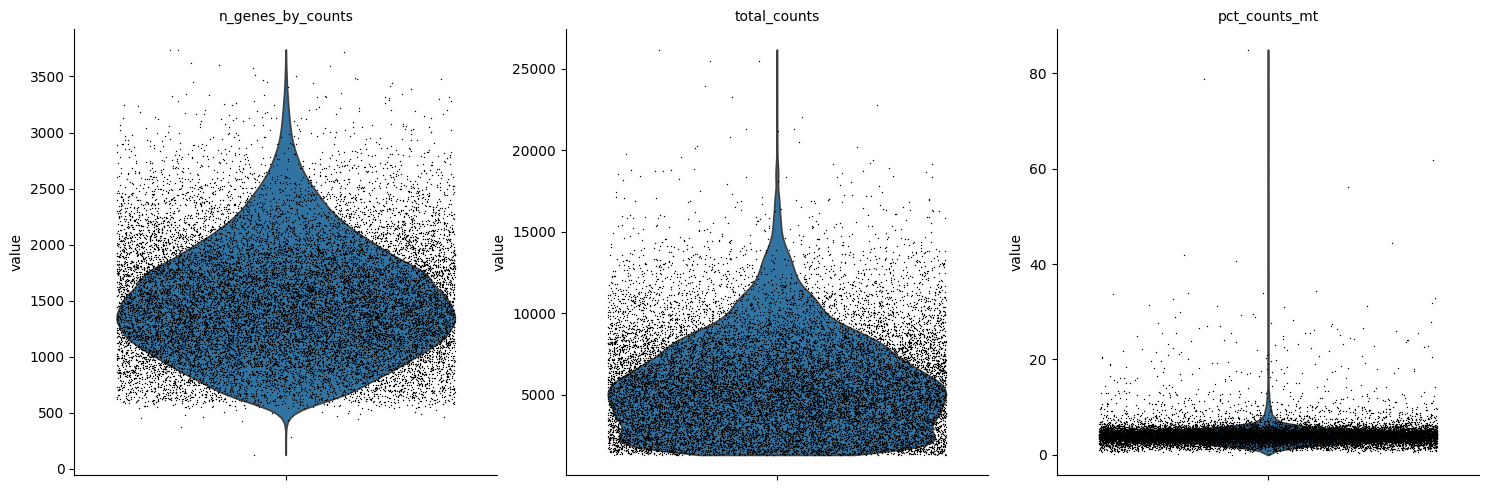

In [15]:
sc.pl.violin(
    adata_whole,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

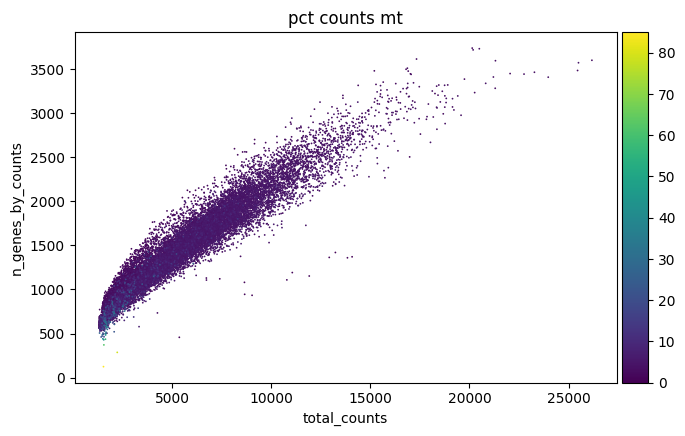

In [16]:
sc.pl.scatter(adata_whole, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [17]:
#No QC or filtering has been done to the above cells, we will firstly filter with low stringency
sc.pp.filter_cells(adata_whole, min_genes=100)
sc.pp.filter_genes(adata_whole, min_cells=3)
adata_whole = adata_whole[adata_whole.obs['pct_counts_mt'] < 10].copy()

In [18]:
#now run scrublet to detect potential doublet cells
sc.pp.scrublet(adata_whole, batch_key = 'batch')

In [19]:
print(adata_whole)

AnnData object with n_obs × n_vars = 17895 × 20620
    obs: 'nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'


In [20]:
adata_whole.obs['predicted_doublet'].value_counts()

predicted_doublet
False    17822
True        73
Name: count, dtype: int64

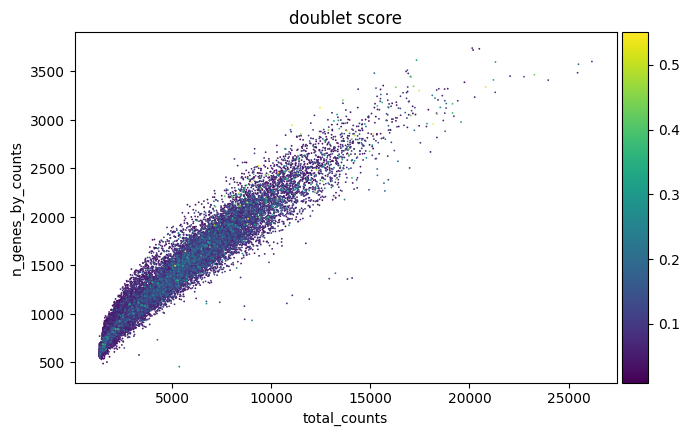

In [21]:
sc.pl.scatter(adata_whole, "total_counts", "n_genes_by_counts", color="doublet_score")

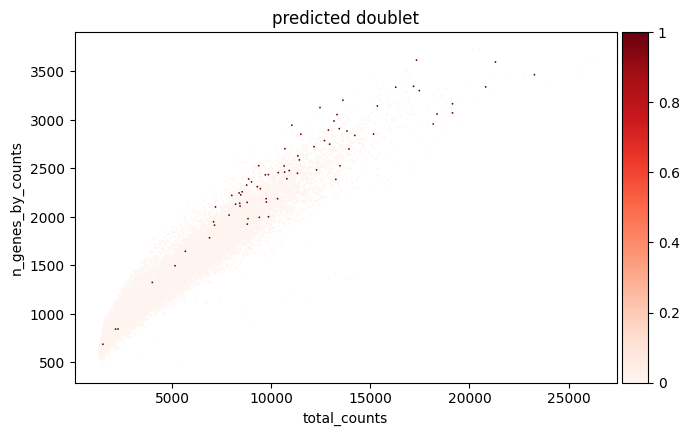

In [22]:
sc.pl.scatter(adata_whole, "total_counts", "n_genes_by_counts", color="predicted_doublet", color_map = "Reds")

In [23]:
adata_whole = adata_whole[adata_whole.obs['predicted_doublet'] == False].copy()

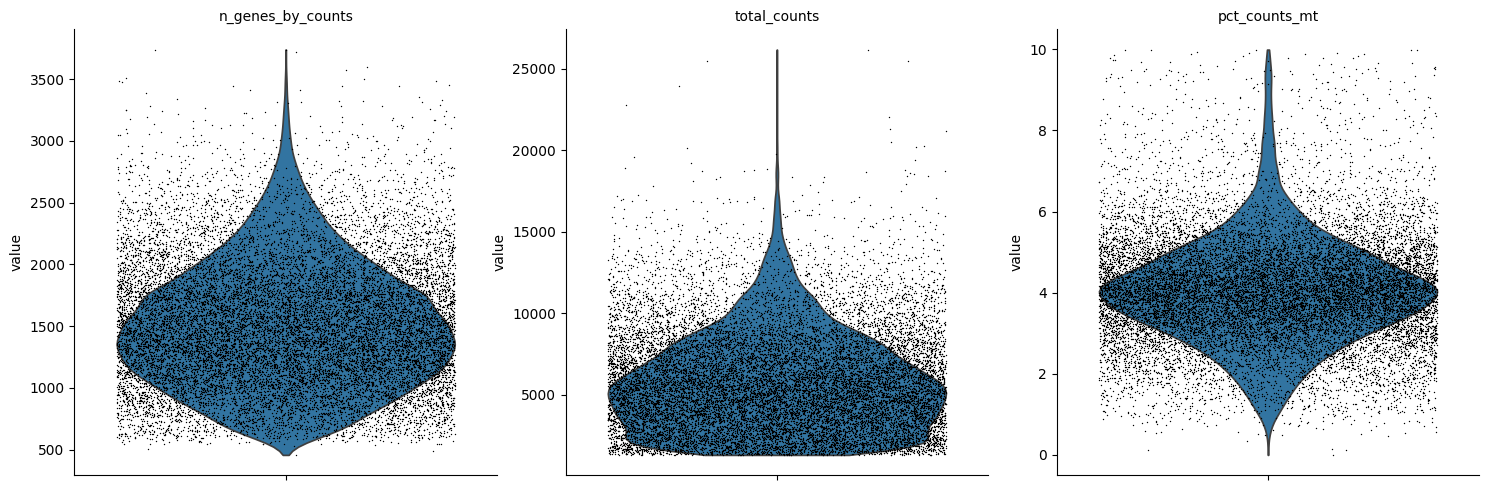

In [24]:
sc.pl.violin(
    adata_whole,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

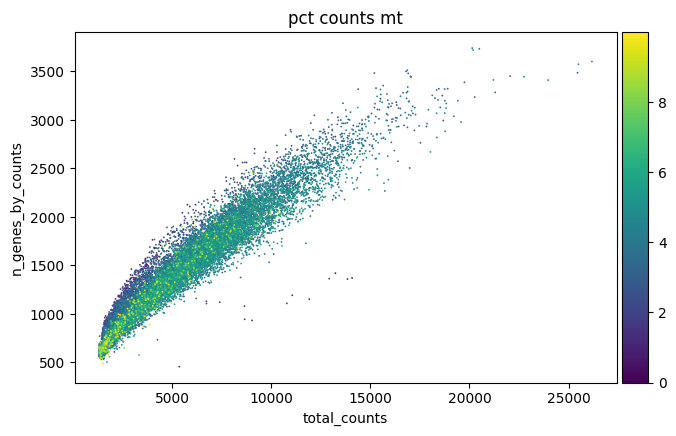

In [25]:
sc.pl.scatter(adata_whole, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [26]:
print(adata_whole)

AnnData object with n_obs × n_vars = 17822 × 20620
    obs: 'nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'


In [27]:
#now we quickly visualise our cells as a check prior to extraction
# Saving count data
adata_whole.layers["counts"] = adata_whole.X.copy()

In [28]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_whole)
# Logarithmize the data
sc.pp.log1p(adata_whole)

In [29]:
sc.pp.highly_variable_genes(adata_whole, n_top_genes=2000, batch_key="batch")


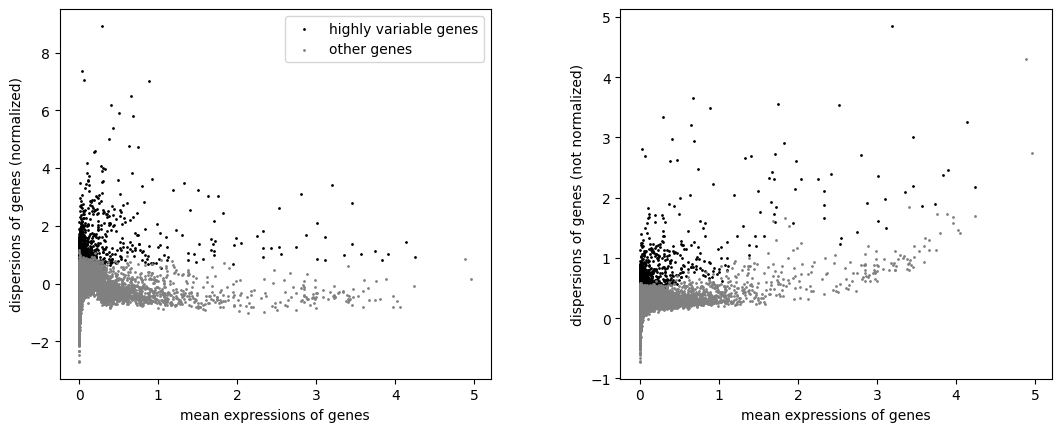

In [30]:
sc.pl.highly_variable_genes(adata_whole)

In [31]:
sc.tl.pca(adata_whole)

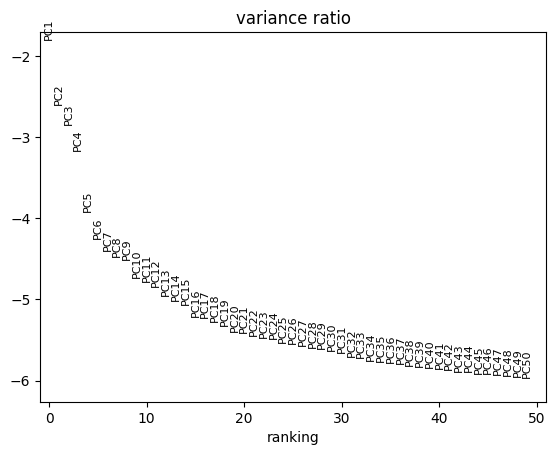

In [32]:
sc.pl.pca_variance_ratio(adata_whole, n_pcs=50, log=True)


In [33]:
sc.pp.neighbors(adata_whole, n_pcs = 30)

/g/data/yr31/hb1618/iPSC_project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
sc.tl.umap(adata_whole)

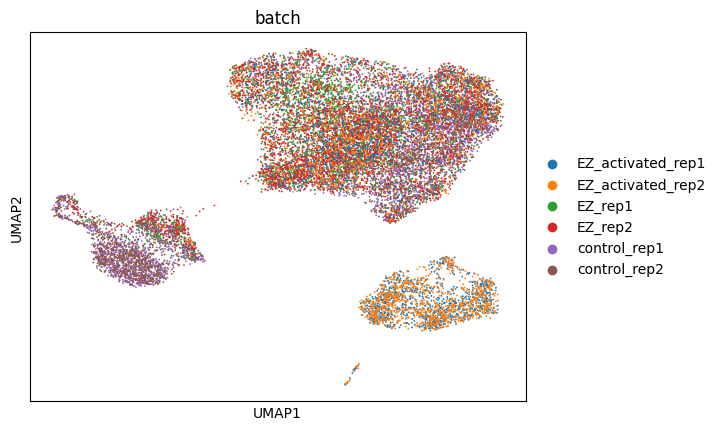

In [35]:
sc.pl.umap(adata_whole, color=["batch"], legend_loc = 'right margin')

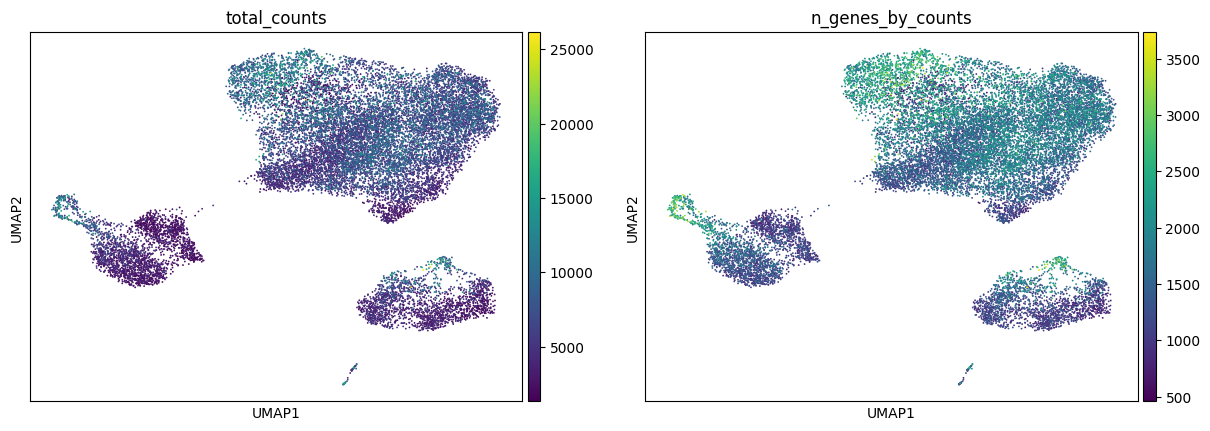

In [36]:
sc.pl.umap(adata_whole, color=["total_counts", "n_genes_by_counts"], legend_loc = 'right margin')

In [37]:
print(adata_whole)

AnnData object with n_obs × n_vars = 17822 × 20620
    obs: 'nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [38]:
#now filtering genes
#n_cells = adata_whole.n_obs
#threshold = round(n_cells * 0.05)
#sc.pp.filter_genes(adata_whole, min_cells=threshold)
sc.pp.filter_genes(adata_whole, min_cells=3)

In [39]:
print(adata_whole)

AnnData object with n_obs × n_vars = 17822 × 20549
    obs: 'nCount_RNA', 'nFeature_RNA', 'replicate', 'treatment', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


In [40]:
#From here we save our obj as a tsv and csv
#exporting extracted data
#exporting count data
# Extract the data from the 'counts' layer of your subsetted object
counts_matrix = adata_whole.layers["counts"]

# Create the DataFrame
# The logic to handle sparse vs. dense arrays is still good to have
counts_df = pd.DataFrame(
    counts_matrix.toarray() if hasattr(counts_matrix, 'toarray') else counts_matrix,
    index=adata_whole.obs_names,
    columns=adata_whole.var_names
)


In [41]:
# Save the DataFrame to a .tsv file
counts_df.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/EZ_T/processed/countdata.tsv", sep='\t')

In [42]:
#exporting metadata
# Save the observation metadata (cell-level annotations) as a CSV file
adata_whole.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/iPSC/EZ_T/processed/metadata.csv")